# Game of Thrones NLP Analysis

In [182]:
import pandas as pd
import numpy as np
import random
import spacy
import nltk
from collections import Counter, defaultdict
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib import colors
import seaborn as sns

sns.set_context('notebook')

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

## 1. Data and Preprocessing

In this notebook I will try to analyze the scripts of one of the most popular and controversial TV shows of all time: **Game of Thrones**. The dataset used was taken from [Kaggle](https://www.kaggle.com/albenft/game-of-thrones-script-all-seasons) and contains each script line of the series, with corresponding speaker's name, episode and season. 

The reason I chose this dataset is that, besides being a fan myself, the show went from being a massive and very praised pop culture phenomenon, to being absolutely hated by most of its fanbase, who critisized its finale (season 8 and, to some extent, season 7). If fans critisize the plot and the plot is contained in the scripts, we may be able to observe a difference in semantics between the first and last seasons.

Here's what the dataset looks like.

In [183]:
data = pd.read_csv('Game_of_Thrones_Script.csv').dropna().reset_index(drop=True)
data

,Release Date,Season,Episode,Episode Title,Name,Sentence
0,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,What do you expect? They're savages. One lot s...
1,2011-04-17,Season 1,Episode 1,Winter is Coming,will,I've never seen wildlings do a thing like this...
2,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,How close did you get?
3,2011-04-17,Season 1,Episode 1,Winter is Coming,will,Close as any man would.
4,2011-04-17,Season 1,Episode 1,Winter is Coming,gared,We should head back to the wall.
...,...,...,...,...,...,...
23903,2019-05-19,Season 8,Episode 6,The Iron Throne,brienne,I think we can all agree that ships take prece...
23904,2019-05-19,Season 8,Episode 6,The Iron Throne,bronn,I think that's a very presumptuous statement.
23905,2019-05-19,Season 8,Episode 6,The Iron Throne,tyrion lannister,I once brought a jackass and a honeycomb into ...
23906,2019-05-19,Season 8,Episode 6,The Iron Throne,man,The Queen in the North!


The actual script is contained in the column *Sentence*, from which we will build our corpus. The following preprocessing steps were performed:

1. Remove **numbers** and **punctuation**, since they do not carry any valuable information needed for our analysis
2. Remove **stopwords**, these are very common words that, again, do not carry valuable information for our purpose
3. Remove words of length 2 characters or less (same as above)
4. Conversion to **lowercase**, this is done to avoid treating words that carry the same exact information as distinct. In fact we do not want to make any distinction between 'Sword' and 'sword' since they mean the same.
5. **Lemmatization**: words are reduced to their base forms, since all the various forms bear the same meaning and we are interested in analysing the semantics of the scripts. 

In [192]:
# this cell takes approximately 2 minutes to run
nlp = spacy.load('en_core_web_sm')

documents = data['Sentence'].to_list()

raw_docs = [[token.text for token in nlp(doc, disable=['parser', 'ner'])] for doc in documents]

pproc_docs = [[token.lemma_.lower() for token in nlp(doc, disable=['parser', 'ner']) 
               if token.is_alpha # remove numbers and punctuation
               and not token.is_stop # remove stopwords
               and len(token.text) > 2] # remove words of length <= 2
               for doc in documents] 

data['CleanText'] = pproc_docs

data = data[data['CleanText'].map(lambda d: len(d)) > 0].reset_index(drop=True) # remove rows with empty sentences

pproc_docs = data['CleanText'].values

First review in the corpus before and after pre-processing.

In [185]:
print('BEFORE:', documents[0])
print('------')
print('AFTER:', pproc_docs[0])

BEFORE: What do you expect? They're savages. One lot steals a goat from another lot and before you know it, they're ripping each other to pieces.
------
AFTER: ['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']


We define the function *docstats* to take a list of documents as input and return some useful statistics on that corpus, such as the number of documents, tokens and types.

The dataframe below provides a comparison between the number of documents, tokens and types in the corpus before and after pre-processing,

In [186]:
def docstats(documents):
    count = len(documents)
    tokens = sum([len(doc) for doc in documents])
    types = len(set([w for doc in documents for w in doc]))
    return (count, tokens, types)

# Table for better visualization
pd.DataFrame(list(zip(docstats(raw_docs), docstats(pproc_docs))),
             columns=['Raw', 'Pre-processed'],
             index=['Documents', 'Tokens', 'Types'])

,Raw,Pre-processed
Documents,23908,22094
Tokens,357579,110109
Types,11684,6556


The difference between the raw and processed corpus is striking if we compare the 10 most common words of the two.

In [187]:
c_raw = Counter([w for doc in raw_docs for w in doc])
c_pproc = Counter([w for doc in pproc_docs for w in doc])

# Table for better visualization
pd.DataFrame({'Raw':[mc[0] for mc in c_raw.most_common(10)],
              'Pre-processed':[mc[0] for mc in c_pproc.most_common(10)]})

,Raw,Pre-processed
0,.,know
1,",",man
2,the,want
3,I,lord
4,you,king
5,to,come
6,?,like
7,a,tell
8,'s,think
9,of,good


Even though this is will not be used in the next part of the notebook, for exploratory purposes it is interesting to see what happens if we use **bigrams** instead of unigrams. As expected, some words carry more meaning when paired with others. In this case we do not use frequency, since simply appearing often together is not enough to make two words a single concept. Therefore, we use **PMI**.

In [189]:
finder = BigramCollocationFinder.from_words([w for doc in pproc_docs for w in doc])
bgm = BigramAssocMeasures()
score = bgm.mi_like

collocations = {'_'.join(bigram): pmi 
                for bigram, pmi in finder.score_ngrams(score)}

Counter(collocations).most_common(10)

[('seven_kingdoms', 47.0596),
 ('casterly_rock', 40.6125),
 ('jon_snow', 35.35596175089754),
 ('king_landing', 31.78494810893641),
 ('castle_black', 21.744315558633424),
 ('grey_worm', 17.806020066889634),
 ('night_watch', 15.405906657503797),
 ('bend_knee', 15.148447204968944),
 ('breaker_chains', 12.071428571428571),
 ('dosh_khaleen', 11.0)]

## 2. Analysis

#### Word Embeddings

In this section we will build word embeddings from our corpus using *gensim*'s **Word2Vec** model. The idea is to project words into a semantic vector space such that words similar in meaning are closer to each other. 

We use word embeddings for two reasons:
1. Analyze the semantics of the script and see how it changes across the 8 seasons.
2. Visualization using t-SNE (in exercise 3)

First, we preprocess our data in order to include **POS tags** (we did not include this step in the pre-processing part since we will only use this input representation in this section). We use POS tags in order to distinguish between words that are written the same but have different meaning depending on the part of speech.

In [190]:
# this cell takes approximately 2 minutes to run
word_corpus = [' '.join(["{}_{}".format(token.lemma_.lower(), token.pos_) 
               for token in nlp(doc, disable=['parser', 'ner']) 
               if not token.is_stop and token.is_alpha and len(token.text) > 2])
               for doc in documents]

word_corpus = [doc.split() for doc in word_corpus if doc != '']

Among the other parameters, we use a *vector size* of 300, which yields good results empirically, and a *window size* of 10, in order to capture semantic more than syntactic similarity. We also use negative sampling and a minimum count of 10.

In [193]:
w2v = Word2Vec(size=300, # vector size
               window=10, # window for sampling
               sample=0.001, # subsampling rate
               iter=200, # iterations
               negative=5, # negative samples
               min_count=10, # minimum threshold
               workers=-1, # parallelize to all cores
               hs=0, # no hierarchical softmax
               seed=0)
w2v.build_vocab(word_corpus)
w2v.train(pproc_docs, total_examples=w2v.corpus_count, epochs=w2v.epochs)

(0, 0)

These are the 10 most similar words to the noun *king*.

In [194]:
w2v.wv.most_similar(['king_NOUN'])

[('matter_NOUN', 0.1921623945236206),
 ('ale_NOUN', 0.186799556016922),
 ('littlefinger_PROPN', 0.18440574407577515),
 ('need_VERB', 0.15977288782596588),
 ('intention_NOUN', 0.1569613814353943),
 ('value_NOUN', 0.15269672870635986),
 ('murder_NOUN', 0.15254634618759155),
 ('appear_VERB', 0.15103566646575928),
 ('dare_VERB', 0.15098997950553894),
 ('offer_VERB', 0.15025413036346436)]

Here we define the function *semantic_by_season* which, given a word as input, provides the *k* most similar words for each of the 8 seasons. 

We can use it to analyze if and to what extent the meaning of words changes during the show.

In [195]:
def semantic_by_season(word,  k=10):
    top_similar = {}
    for s in range(1, 9):
        season = 'Season {}'.format(s)
        minidx = data[data['Season'] == season].index.min()
        maxidx = data[data['Season'] == season].index.max()
        docs = word_corpus[minidx:maxidx + 1]
        model = Word2Vec(size=300, # vector size
                   window=10, # window for sampling
                   sample=0.001, # subsampling rate
                   iter=200, # iterations
                   negative=5, # negative samples
                   min_count=10, # minimum threshold
                   workers=-1, # parallelize to all cores
                   hs=0, # no hierarchical softmax
                   seed=0)
        
        model.build_vocab(docs)
        model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)
        
        top_similar[season] = [w[0] for w in model.wv.most_similar([word], topn=k)]
    
    df = pd.DataFrame(top_similar)
    return df

Here we provide the 5 most similar words to *king* and *winterfell* (for those unfamiliar with the show, Winterfell is the house to one of the main families),

In [196]:
semantic_by_season('king_NOUN', k=5)

,Season 1,Season 2,Season 3,Season 4,Season 5,Season 6,Season 7,Season 8
0,matter_NOUN,need_VERB,matter_NOUN,need_VERB,matter_NOUN,need_VERB,need_VERB,need_VERB
1,need_VERB,offer_VERB,need_VERB,murder_NOUN,need_VERB,mormont_PROPN,appear_VERB,life_NOUN
2,gold_NOUN,gold_NOUN,gold_NOUN,tommen_PROPN,mormont_PROPN,surrender_VERB,mormont_PROPN,dead_ADJ
3,life_NOUN,poor_ADJ,poor_ADJ,gold_NOUN,tommen_PROPN,life_NOUN,gold_NOUN,matter_VERB
4,hate_VERB,robb_PROPN,robb_PROPN,lie_NOUN,gold_NOUN,sorry_ADJ,life_NOUN,protect_VERB


The results are not particularly insightful and the cosine similarity (shown before in the results for the 10 most similar words to king) rarely goes above 0.30 (never for the word king).

#### Document Embeddings

In this part we try a different approach and use document embeddings instead of word embeddings. In fact, since we have data on the speaker and the season of the script line, we can use document embeddings to analyze language variation across two dimensions: *character* and *season*. 

To do so, we use *gensim*'s **Doc2Vec** model. We use the same parameters set for the word2vec model except for: a vector size of 100, distributed bag of words as training algorithm and we set *dbow_words = 1* to train both doc and word vectors.

In [199]:
corpus = []

for row in data.iterrows():
    character = row[1].Name
    season = row[1].Season
    text = row[1].CleanText
    corpus.append(TaggedDocument(words=text, 
                                 tags=[character, season]))
    
d2v_model = Doc2Vec(vector_size=100, 
                    window=10,
                    hs=0,
                    sample=0.0001,
                    negative=5,
                    min_count=10,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1,
                    seed=0)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

We will use the document embeddings just created to find characters sharing a similar language and observe how this similarity changes across the 8 seasons. To do so, we define the function *similar_characters*, which takes a character as input and returns the *K* most similar characters for each season.

In [200]:
def similar_characters(character, k=10):
    top_similar = {}
    for i in range(1, 9):
        season = 'Season {}'.format(i)
        target_doc = [character, season]
        top_similar[season] = [w[0] for w in d2v_model.docvecs.most_similar(target_doc, topn=k)]
    df = pd.DataFrame(top_similar)
    return df

In [201]:
similar_characters('arya stark', k=5)

,Season 1,Season 2,Season 3,Season 4,Season 5,Season 6,Season 7,Season 8
0,lhara,brans voice,morgans friend,morgans friend,giant,morgans friend,knight of house whent,morgans friend
1,harrag,wildling elder,announcer,all together,waldery frey,little sam,lord mormont,daisy
2,giant,shireen,catelyn stark,steward of house stark,syrio forel,farmer hamlet,orell,renly
3,morgans friend,belicho,hizdahr zo loraq,leader,brans voice,everybody,shireen,steward of house stark
4,mhaegen,knight of house whent,group,armory,sand snakes,deanerys targarian,waldery frey,knight of house whent


In [202]:
similar_characters('jaime lannister', k=5)

,Season 1,Season 2,Season 3,Season 4,Season 5,Season 6,Season 7,Season 8
0,selyse,yohn,yoren,ygritte,thin man,dagmer,harpy,sammy
1,mordane,barriston,thin man,sammy,lord royce,walda,umber,yohn
2,brienne,jaremy rykker,catelyn stark,knight,unsullied,rikon,portan,renly
3,harrag,lannister scout,announcer,lannister scout,officer,oberyn martell,rickon,unsullied
4,robb stark,roose bolton,robett glover,slave owner,warg,yoren,martyn,thin man


We would  expect similar characters to share a similar language (e.g. children similar to other children or warriors similar to other warriors). We are able to capture some of this similarity for Jaime Lannister, who is a warrior and we can see share similarities with other warrios (but then we realize that half of all the characters are warriors, so results may not be significant). For other characters, the similarity is not evident.

Could similarity be more related to the plot instead? Since GOT is organized in subplots, characters in the same subplot could show a similar language. Again, from the results above it is not clear whether we are actually able to capture this similarity using document embeddings.

#### TF-IDF

In this section we will apply TF-IDF to our set of documents. Unlike the previous two methods, which produced dense representations, TF-IDF is a discrete representations. This has the disadvantage of producing high-dimensional sparse matrices as input, but its results are more easily interpretable than those of continuous representations.

We will use TF-IDF for the following purposes:
- To find important words appearing very frequently in not many documents.
- As input to SVD to reduce dimensionality and visualize semantic similarity across characters and seasons.

To produce the TF-IDF representation of documents we use *sklearn*'s TfidfVectorizer, whereas we use CountVectorizer to produce a simple frequency representation (used for visualization purposes). For both we use unigrams and bigrams, we remove stop-words and words occurring too frequently or too rarely. For TF-IDF we use sublinear tf, meaning that we use a version of TF-IDF implementing smoothing and log scaling.

In [203]:
docs = [' '.join(doc) for doc in pproc_docs]

tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(1,3),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(docs)

In [204]:
count_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(1,3),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7)

X2 = count_vectorizer.fit_transform(docs)

In [206]:
X.shape

(22094, 897)

In [207]:
df = pd.DataFrame({'word': count_vectorizer.get_feature_names(), 
                   'tf': X2.sum(axis=0).A1, 
                   'idf': tfidf_vectorizer.idf_,
                   'tfidf': X.sum(axis=0).A1}).sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index(drop=True)

df.iloc[:10]

,word,tf,idf,tfidf
0,know,1577,3.758165,579.083761
1,want,1233,4.000041,441.807401
2,lord,1183,3.979348,417.039875
3,come,1094,4.086392,415.274769
4,man,1480,3.832987,408.685869
5,like,931,4.248503,333.240915
6,king,1172,4.057093,332.960017
7,think,807,4.358016,321.747765
8,tell,829,4.377714,316.219003
9,good,787,4.415557,306.766812


#### Text Generation

In this section we take a little detour from the previous analyses and try to build a **Language Model** to generate both generic and character-specific GOT script lines (it should be hard to do a worse job than last season's writers).

For this task, we build the class *LanguageModel*, which is initialized to a given ngram size and smoothing parameter. The other class methods are:
- *fit*: used to build the actual model
- *generate*: used to generate sentences, either from scratch or starting from a given sentence
- *sample_next_word*: used in the generate method to sample a new word given (*n-1*) previous words, where *n* is the ngram size 

In [208]:
corpus = [doc.split() for doc in documents]

In [211]:
class LanguageModel:
    
    
    def __init__(self, ngram=4, smoothing=0.001):
        self.ngram = ngram
        self.smoothing = smoothing
        self.counts = defaultdict(lambda: defaultdict(lambda: smoothing))
        self.START = '_***_'
        self.STOP = '_STOP_'
    
    def fit(self, corpus):
        for sentence in corpus:
            # include special tokens for start and the end of sentence
            tokens = [self.START for i in range(self.ngram - 1)] + sentence + [self.STOP]
            for words in nltk.ngrams(tokens, self.ngram):
                k = words[:-1]
                v = words[-1]
                self.counts[k][v] += 1
    
    def generate(self, words=[]):
        if words:
            words = words.split()
        result = [self.START for i in range(self.ngram - 1)] + words
        # sample the first word
        previous_words = tuple(result[-(self.ngram - 1):])
        next_word = self.sample_next_word(previous_words)
        result.append(next_word)
        while next_word != self.STOP:
            previous_words = tuple(result[-(self.ngram - 1):])
            next_word = self.sample_next_word(previous_words)
            result.append(next_word)
        
        return ' '.join(result[(self.ngram - 1):-1])
    
    def sample_next_word(self, previous_words):
        # if previous words were not observed before, a random tuple of words is drawn
        if list(self.counts[previous_words].values()) == []:
            previous_words = random.choice(list(self.counts.keys()))
        # separate word and their counts into separate variables
        keys, values = zip(*self.counts[previous_words].items())
        # normalize the counts into a probability distribution
        values = np.array(values)
        values /= values.sum() # create probability distro
        # this is the meat of the function
        sample = np.random.multinomial(1, values) # pick one position
    
        return keys[np.argmax(sample)]

Let's see how are languge model performs and how does the ngram size affects performance.

In [212]:
lm = LanguageModel(6)
lm.fit(corpus)

In [214]:
lm.generate()

'The Sons of the Harpy have a good story. Resist the foreign invaders. Our queen has an even better story. Mother of Dragons, Breaker of Chains, long may she reign.'

In [215]:
lm.generate('What do we say to')

'What do we say to the God of death?'

In [218]:
lm.generate('I love to eat')

'I love to eat cripple. old.'

In [219]:
lm = LanguageModel(3)
lm.fit(corpus)

In [220]:
lm.generate()

'It appears to have me killed?'

In [221]:
lm.generate('What do we say to')

'What do we say to them.'

As the results above show, an ngram size of 6 produces the original sentences on which the model was built, if the sentences are produced from scratch or if the starting of a sentence found also in the original set is provided as input. However, if we provide as starting sentence a completely new one, we see that the model produces new sentences, even though the quality declines.

If instead we use an ngram size of 3, the model always produces new sentences, although sometimes of doubious quality.

Let's try to build a character-specific language model in order to generate script lines for a given character. We do so through the function *generate_character_line*, which builds a language model on a character's corpus and uses said model to generate a sentence for that given character. Just for fun, we use this function inside the function *generate_script* to generate a fictitious dialogue between two characters.

In this case, considering the smaller size of the character-specific corpus we need to reduce the ngram size and therefore use trigrams.

In [222]:
def generate_character_line(character, ngram=3, words=[]):
    character_docs = data[data['Name'] == character]['Sentence'].to_list()
    character_corpus = [doc.split() for doc in character_docs] 
    lm = LanguageModel(ngram)
    lm.fit(character_corpus)
    
    return lm.generate(words)

def generate_script(characters, length=10):
    text = ''
    for i in range(length):
        speaker = characters[i % 2]
        text += speaker.upper() + ': '
        text += generate_character_line(speaker)
        text += '\n\n'
    return text

In [223]:
print(generate_script(['daenerys targaryen', 'jon snow']))

DAENERYS TARGARYEN: turns to look at MISSANDEI. She then continues walking.

JON SNOW: Sam. . Maester Aemon?

DAENERYS TARGARYEN: He said he had to be.

JON SNOW: She...she had red hair.

DAENERYS TARGARYEN: Would you like to see them one day?

JON SNOW: My friends brought me home. I know where to put it.

DAENERYS TARGARYEN: Is that all I am to you?

JON SNOW: Get your shield up. Or I'll ring your head like a kite with his strings cut or does he do with his sons?

DAENERYS TARGARYEN: And what of my magic? You saw me step into the slaughterhouse.

JON SNOW: Good.




Of course, the dialogue is completely detached from reality given that our simple model does not take into account dialogue history or topics. Despite the extreme simplicity of our text generation model, this is a nice example of an application of language models and also an example of the difficulties of generating coherent dialogues. 

#### SVD & Clustering

In this section we will first apply **SVD** to reduce the dimensionality of the TF-IDF transformed data. Then we will use the obtained reduced data as input to two clustering algorithms. In particular, we want to apply both **agglomerative** and **K-means clustering**. The reason is that agglomerative clustering allows us to have reproducible results, but can only be applied to a subset of our corpus for computational reasons. Therefore, in order to find clusters for the whole corpus, we use the cluster centroids found through agglomerative clustering as the initial centroids of a K-Means algorithm on the whole dataset.

Therefore we perform the following steps:
1. Apply SVD to the TF-IDF representation of the corpus. In this step we reduce dimensionality from 897 to 50 latent dimensions.
2. Sample a subset of 10000 documents from our original corpus
3. Apply agglomerative clustering to the subset, testing a wide range of values of the parameter K (number of clusters). We use the optimal value as the parameter of choice, where optimality is established using the silhouette score
4. Inizialize a K-Means algorithm to the centroids found in the previous step and fit the model
5. Use the output of the previous step for visualization

In [224]:
X_reduced = TruncatedSVD(n_components=50).fit_transform(X)
sample = np.random.choice(len(X_reduced), replace=False, size=10000)

In [225]:
# this cell should take approximately 1 minute to run
silhouettes = []

K = range(2, 10) # range reduced to speed up computation, tested range was (2, 40)

for c in K:
    agg = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg.fit_predict(X_reduced[sample])
    score = silhouette_score(X_reduced[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)

2 0.4241319841769815
3 0.2781568890050596
4 0.28579811338051725
5 0.2625133680098723
6 0.202764754085255
7 0.20819200678460328
8 0.21334422975487363
9 0.2187265852722729


The number of clusters associated to the highest silhouette score is 2. Notice: even though the code shows a test on the range 2 to 10 clusters, in reality I tested up to 40 clusters and reduced the range afterwards to speed up the computation.

In [226]:
best_n = K[np.argmax(silhouettes)]
agg = AgglomerativeClustering(n_clusters=best_n)
agg_cluster_ids = agg.fit_predict(X_reduced[sample])

#K-Means
centroids = np.array([X_reduced[sample][agg_cluster_ids == c].mean(axis=0) for c in range(best_n)])
km = KMeans(n_clusters=best_n, init=centroids)
km.fit(X_reduced)

C:\Users\dioge\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[ 5.13183125e-02,  6.13608343e-02, -6.74800856e-03,
         1.97221384e-02, -3.31942323e-03, -2.03564472e-02,
         1.24706433e-03,  6.25189691e-04, -2.15202884e-04,
         3.05349420e-04, -1.56130320e-03,  1.16580144e-02,
        -5.18495777e-03,  8.50735608e-03,  4.43847347e-03,
         1.81320120e-03,  1.82720956e-03,  7.23806020e-03,
         1.33458288e-02,  7.56042272e-04, -3.23330247e-03,
         3.082418...
        -9.19977123e-04, -2.02324200e-02,  4.40322065e-03,
         6.93859642e-03,  6.18781517e-03, -7.56339371e-03,
         2.18124476e-03,  5.26532901e-03,  6.69815873e-04,
         7.05579655e-03, -1.54350461e-02, -1.02220484e-02,
         4.35253642e-04, -1.06044046e-02,  9.42699691e-04,
        -6.27622633e-03, -4.38676014e-03, -1.66276992e-04,
        -1.32997059e-02,  3.29513762e-03, -6.04022421e-03,
        -3.64658018e-04, -3.37068118e-03]]),
       n_clusters=2)

## 3. Visualization

#### TF-IDF Visualization

To start with, let's do a scatter plot of the TF-IDF representation of the corpus we found in the previous section. For each word in the corpus we can visualize the TF-IDF on the x-axis and the IDF. Each point's size and color varies according to the TF of the word. Points with a TF-IDF value greater than 400 are annotated.

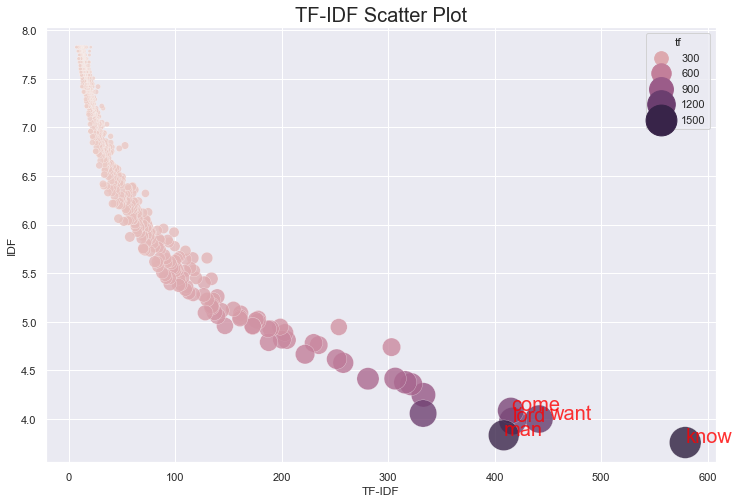

In [227]:
plt.figure(figsize=(12,8))
#plt.scatter(df['tfidf'], df['idf'], s=df['tf'])
sns.set_style('darkgrid')
sns.scatterplot(x=df['tfidf'], y=df['idf'], size=df['tf'], hue=df['tf'], sizes=(10, 1000), alpha=0.8)

for label, x, y, s in zip(df['word'], df['tfidf'], df['idf'], df['tf']):
    if label in df[:5]['word'].values:
        if x > 420 and x < 500: # avoid annotation overlapping for close values
            x += 10
        plt.annotate(label, 
                     xy=(x, y), 
                     fontsize=20, 
                     color='red', 
                     alpha=0.8)

plt.title('TF-IDF Scatter Plot', fontsize=20)
plt.xlabel('TF-IDF', fontsize=12)
plt.ylabel('IDF', fontsize=12)
plt.show()

Looking at the graph and the results of the table of the 10 words with the greatest TF-IDF (in the previous exercise), we clearly see that the high TF-IDF of these words is a byproduct of their really large term frequency. As a result, we are not able to capture any interesting words.

It is interesting to notice how we get much more interesting results if we only consider bigrams instead.

In [228]:
tfidf_vectorizer_bi = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(2,3),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True)

X_bi = tfidf_vectorizer_bi.fit_transform(docs)

count_vectorizer_bi = CountVectorizer(analyzer='word', 
                                   ngram_range=(2,3),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7)

X2_bi = count_vectorizer_bi.fit_transform(docs)

df2 = pd.DataFrame({'word': count_vectorizer_bi.get_feature_names(), 
                   'tf': X2_bi.sum(axis=0).A1, 
                   'idf': tfidf_vectorizer_bi.idf_,
                   'tfidf': X_bi.sum(axis=0).A1}).sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index(drop=True)

df2.iloc[:10]

,word,tf,idf,tfidf
0,king landing,194,5.756083,168.667056
1,jon snow,127,6.199086,106.880632
2,night watch,122,6.215615,99.732600
3,seven kingdoms,98,6.418139,86.757545
4,castle black,91,6.514470,76.527647
5,lord commander,82,6.621080,67.188560
6,look like,72,6.726440,67.003843
7,ned stark,71,6.754611,62.247642
8,iron throne,63,6.844224,56.188710
9,lord light,59,6.960055,54.045117


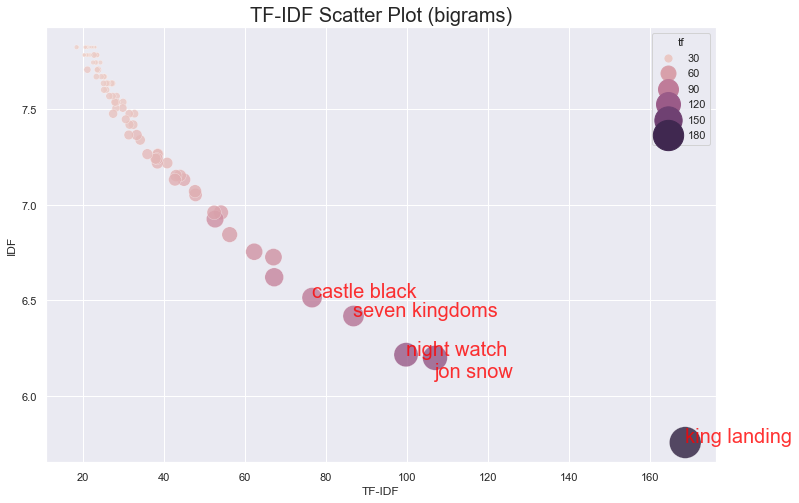

In [229]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.scatterplot(x=df2['tfidf'], y=df2['idf'], size=df2['tf'], hue=df2['tf'], sizes=(10, 1000), alpha=0.8)

for label, x, y, s in zip(df2['word'], df2['tfidf'], df2['idf'], df2['tf']):
    if label in df2[:5]['word'].values:
        if x > 100 and x < 120: # avoid annotation overlapping for close values
            y -= 0.1
        plt.annotate(label, 
                     xy=(x, y), 
                     fontsize=20, 
                     color='red', 
                     alpha=0.8)

plt.title('TF-IDF Scatter Plot (bigrams)', fontsize=20)
plt.xlabel('TF-IDF', fontsize=12)
plt.ylabel('IDF', fontsize=12)
plt.show()

#### SVD Visualization

In this section we will apply SVD to our TF-IDF matrix in order to reduce its dimensionality for visualization purposes. In particular, we will project our documents into 3 dimensions and we will try to observe similarity of script lines:
- Between the 5 characters with most lines: this allows us to observe whether there is significant semantic variation between characters and if some characters have a more similar language than others.
- Between seasons: this allows us to check whether language changes between the first and last seasons.

In [230]:
def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3, legend=False, annotations=False):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(14,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('spring') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
    
    df = df.dropna()
    
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()
    
    # annotations and legend
    plt.title(title)
    if legend:
        plt.legend()
    if annotations:
        if dimensions == 2:
            for lab, x, y in zip(annotations, vectors[:, 0], vectors[:, 1]):
                plt.annotate(lab, 
                             xy=(x, y), 
                             bbox=dict(boxstyle="round", fc="w"),
                             arrowprops=dict(arrowstyle="->"))
        else:
            x2, y2, _ = proj3d.proj_transform(df['x'], df['y'], df['z'], ax.get_proj())
            for lab, x, y in zip(annotations, x2, y2):
                plt.annotate(lab, 
                             xy=(x, y), 
                             bbox=dict(boxstyle="round", fc="w"),
                             arrowprops=dict(arrowstyle="->"))     
    plt.show()

Let's check who are the 5 characters with the most lines.

<AxesSubplot:xlabel='Name'>

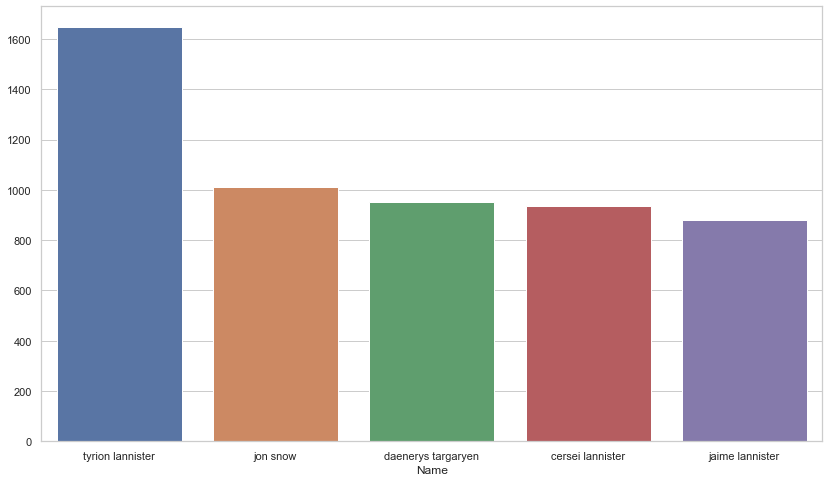

In [232]:
top5char = data.groupby('Name')['Sentence'].count().sort_values(ascending=False)[:5]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14,8))
sns.barplot(x=top5char.index, y=top5char.values, data=data)

These 5 characters account for about 1/4 of the entire corpus. We restrict our corpus to the lines of these 5 characters only, hence reducing the corpus size to 5428. We use character names as labels and plot the 3d projection of the TF-IDF representation of this subset of the corpus.

Proportion of lines of the 5 top characters over total number of script lines: 0.2456775595184213


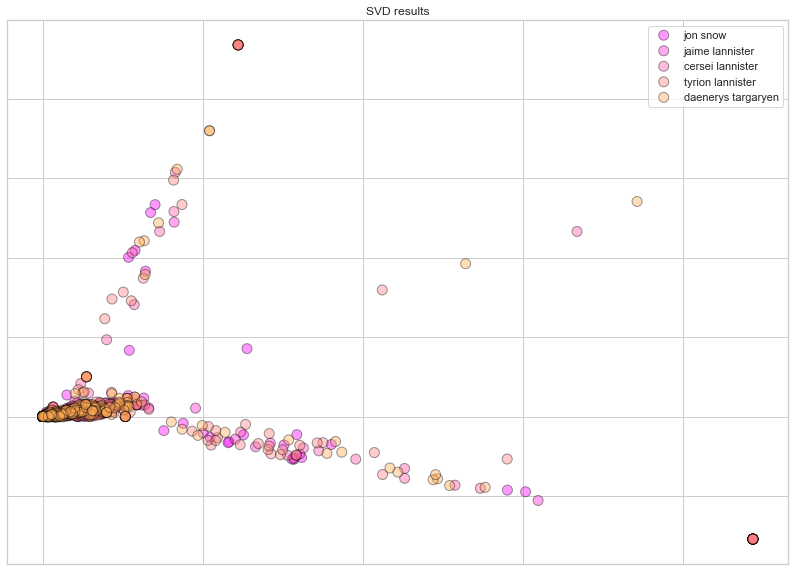

In [233]:
top5data = data[data['Name'].isin(top5char.index.values)]
print('Proportion of lines of the 5 top characters over total number of script lines:', len(top5data)/len(data))
top5data_tfidf = X[top5data.index.values - 1]
SVD = TruncatedSVD(n_components=2).fit_transform(top5data_tfidf)
names = top5data['Name']

plot_vectors(SVD, title='SVD results', labels=names, dimensions=2, legend=True)

The graph shows significant semantic overlapping across characters, with few rare exceptions. Hence, it would appear that characters share a similar language. This makes sense if we think that many words with a high TF-IDF score like "king", "know" or "lord" are used very often by all characters. 

Let's now see if we can observe any semantic difference between seasons. In particular we divide the 8 seasons into 4 groups of 2 seasons for better visualization. 

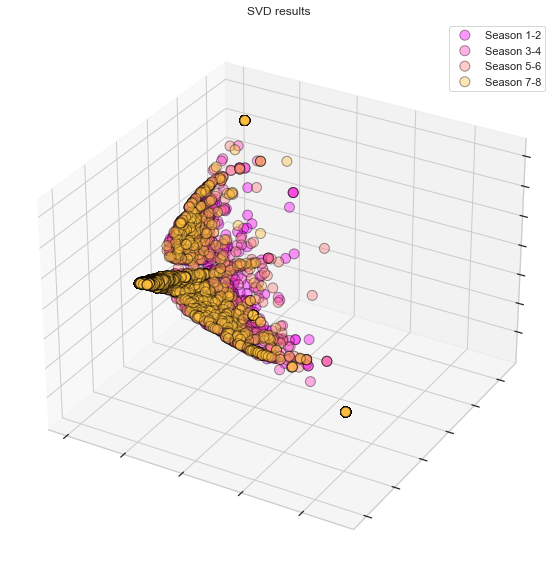

In [234]:
data['SeasonGroup'] = np.empty((len(data)))
data.loc[data['Season'].isin(['Season 1', 'Season 2']), 'SeasonGroup'] = 'Season 1-2'
data.loc[data['Season'].isin(['Season 3', 'Season 4']), 'SeasonGroup'] = 'Season 3-4'
data.loc[data['Season'].isin(['Season 5', 'Season 6']), 'SeasonGroup'] = 'Season 5-6'
data.loc[data['Season'].isin(['Season 7', 'Season 8']), 'SeasonGroup'] = 'Season 7-8'

SVD2 = TruncatedSVD(n_components=3).fit_transform(X)
seasons = data.SeasonGroup
plot_vectors(SVD2, title='SVD results', labels=seasons, dimensions=3, legend=True)

We can see that the first half of the show has a somewhat less similar semantics than the other seasons, even though there is still much overlapping across all seasons. Again, this makes sense since most words appear indistinctly across seasons. Words that would justify a change in semantic (for example as the plot of the show changes) are too few, which makes such a change in semantics apparently unobservable.

#### Clustering

In this part we use the clusters found in exercise 2 in order to visualize the data.

Firstly, let's plot the silhouette score as a function of the number of clusters.

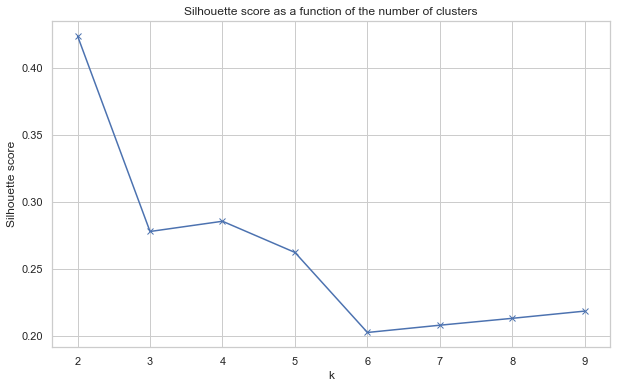

In [235]:
# Clustering
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style('whitegrid')
plt.plot(K, silhouettes, 'bx-');
plt.xlabel('k');
plt.ylabel('Silhouette score');
plt.title('Silhouette score as a function of the number of clusters');

As we have seen in the previous exercise, testing a range of 2 to 40 clusters, 2 was the value associated with the highest silhouette score and hence the one we provide as input to the agglomerative clustering algorithm.

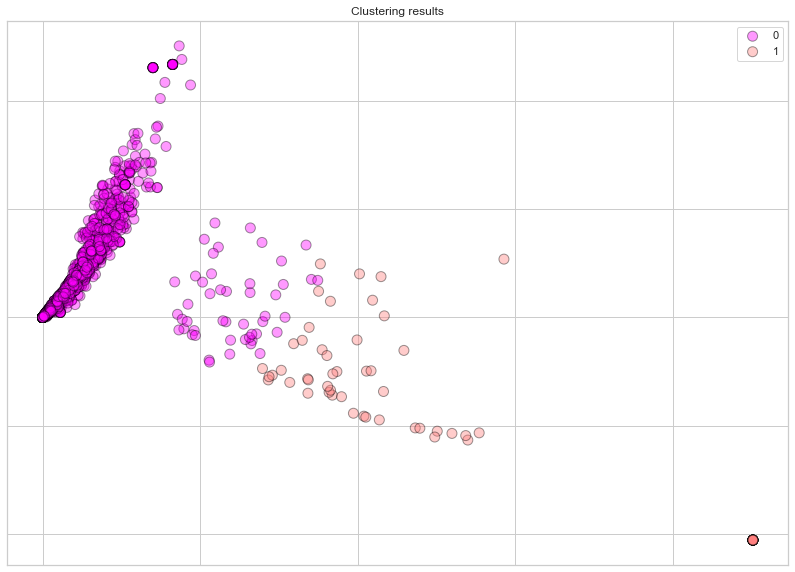

In [236]:
plot_sample = np.random.choice(len(X_reduced), replace=False, size=2000)
plot_vectors(X_reduced[plot_sample], title='Clustering results', labels=km.labels_[plot_sample], dimensions=2, legend=True)

Looking at the graph above, we see that a part of cluster 0 is very compact and close in the projected space, whereas another part is more scattered and it is not clear how the line is drawn between the two clusters. Let's try to analyze a few cleaned sentences from both clusters to check if we can gain some insights.

In [237]:
np.random.seed(10)
cluster1ex = np.random.choice(data.index.values[km.labels_ == 1], 10, replace=False) # sample 10 sentences from cluster 1
cluster0ex = np.random.choice(data.index.values[km.labels_ == 0], 10, replace=False) # sample 10 sentences from cluster 0
pd.DataFrame({'Cluster 0': data.iloc[list(cluster0ex)]['CleanText'].values, 'Cluster 1': data.iloc[list(cluster1ex)]['CleanText'].values})

,Cluster 0,Cluster 1
0,"[poison, enemy]","[yes, thank, know]"
1,"[woman, murder, mother, father, brother, dange...","[know, free]"
2,[credit],"[hardhome, know]"
3,"[come, kiss]","[know, cersei, tell, come, destroy, city]"
4,"[king, joffrey, baratheon, grace]","[sudden, look, way, give, little, smile, like,..."
5,"[love, girl, like, good, kind, kill]","[know, head, great, family]"
6,"[army, service, gods, course, choose, represen...","[know, take, war, hungry, fall, sick, kill]"
7,"[see, young, greyjoy, lad, winterfell, like, s...","[maybe, know, ramsay]"
8,"[cowardo, weapon, like, fight, close, like, ma...","[know, persuasive, try, fuck]"
9,"[help, help]","[ygritte, know, choice, know]"


The sample shows that clusters are formed around words with a very high TF-IDF value (e.g. "Man", "Stay", "Know") and we showed in the previous section on TF-IDF that the high value was caused by a very large term frequency. Therefore, the cluster analysis does not really provide any valuable insights on the semantics of the corpus. (Notice: I set a seed of 10 just to comment results and if the seed is changed the sense of the comments does not change, however the high TF-IDF words around which clusters are formed may change)

#### t-SNE

So far we have tried to visualize our data using discrete representation of documents. In this final part, we will instead use t-SNE to visualize the word and document embeddings found in exercise 2.

Let's start with word embeddings. The interpretation of t-SNE plots is that points close to each other are words whose embeddings are similar and hence occur in similar contexts. t-SNE is sensitive to the set of parameters provided, with special emphasis on *perplexity*. For this reason many perplexity values were tried and a value of 50 was eventually selected (tests were later removed to speed up the code).

In [238]:
X_w2v = w2v.wv[w2v.wv.vocab]
tsne = TSNE(n_components=2, perplexity=50)
X_tsne = tsne.fit_transform(X_w2v)

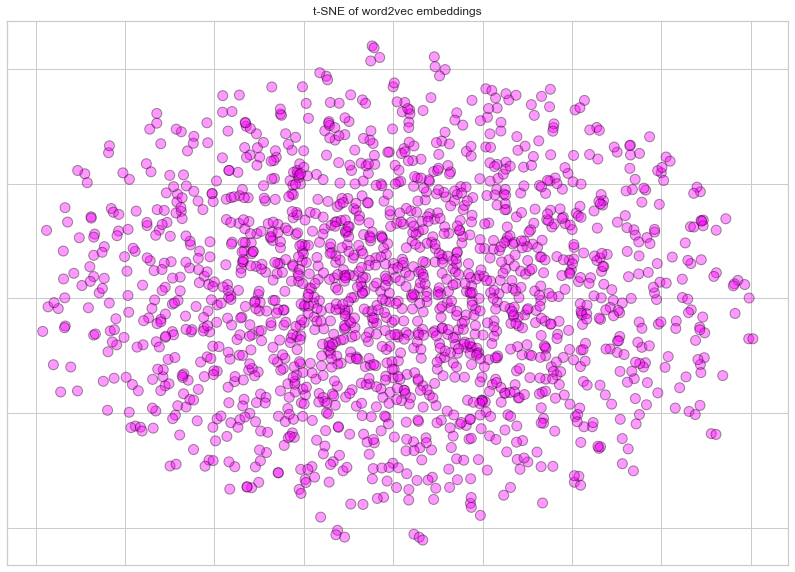

In [239]:
plot_vectors(X_tsne, title='t-SNE of word2vec embeddings', dimensions=2)

The results show an undistinguishable cluster of word embeddings. Let's se what happens if we annotate the data.

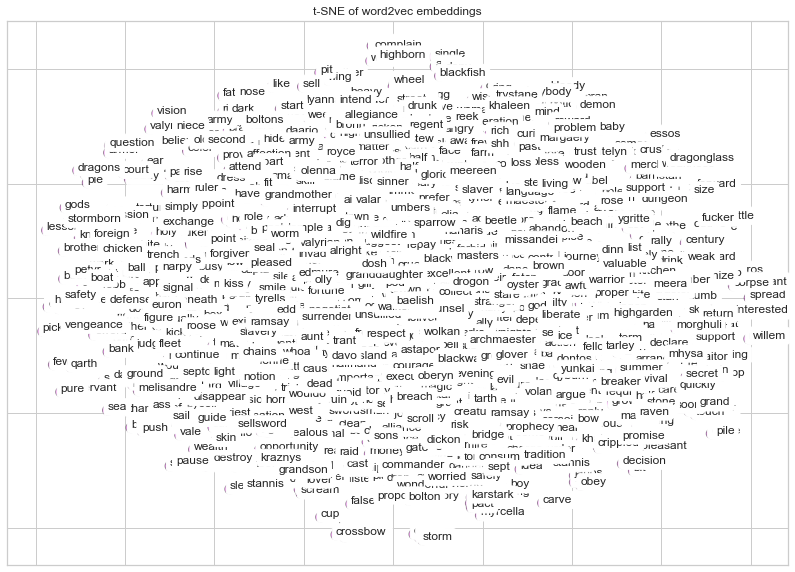

In [240]:
a = [label.split('_')[0] for label in list(w2v.wv.vocab.keys())] # remove POS from annotations
plot_vectors(X_tsne, title='t-SNE of word2vec embeddings', dimensions=2, annotations=a)

Looking at the crowded graph above, it looks like words we would expect to occur in similar contexts and hence be more similar are not actually close in the projected space. 

Let's try to do the same with the document embeddings found in exercise 2. The documents were labeled according to the character and season of the script line.

In [241]:
tsne2 = TSNE(n_components=3, n_iter=300, perplexity=50)
d2v_tsne = tsne2.fit_transform(d2v_model.docvecs.vectors_docs)

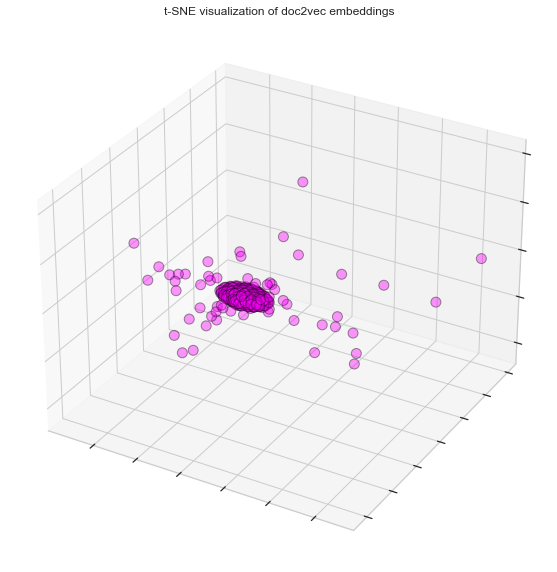

In [242]:
plot_vectors(d2v_tsne, title='t-SNE visualization of doc2vec embeddings', dimensions=3)

We clearly see that most documents are very close to each other in the projected space, with a handful of exceptions. This seems to confirm the results found in the SVD visualization part, in which we were not able to find any significant semantic differences across characters or seasons.

This may indicate that semantics may not be a very relevant dimension on which characters or seasons of this TV show can be compared. It makes sense considering that *most* language is very coherent across the entire length of the show and that the number of documents relevant to capture semantic differences between characters or different parts of the story is relatively small, compared to the overall size of the corpus. 

#### Thank you!